In [83]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix' # latex like
matplotlib.rcParams['font.family'] = 'STIXGeneral' # latex like

## Part 1

#### 1. Derive the corresponding Boundary Value Problem (BVP) for the displacement field u : [0, L]→R using the equilibrium equation for 1D problems (strong form).

Define variables

In [84]:
x = sp.Symbol('x',real=True)
u = sp.Function('u',real=True)(x)
u_xx = u.diff(x,2)
L, g, F, A, E = sp.symbols('L g F A E')
rho = sp.pi**3/L**2
s = g*sp.pi**4/L**2
r = (x/L)**2
b = g*sp.pi**2/L

Define the differential equation

In [85]:
ode = sp.Eq(u_xx + rho*u - s*r,0)
display(ode)

Eq(Derivative(u(x), (x, 2)) + pi**3*u(x)/L**2 - pi**4*g*x**2/L**4, 0)

---

#### 2. Find the exact solution of this BVP. Plot in a graph the solution of the problem using the following values of the involved constants and the function r = r(x/L):

Solve the differential equation

In [86]:
sol = sp.dsolve(ode, ics={u.subs(x,0):-g, u.diff(x).subs(x,L):b})
display(sol)

Eq(u(x), -2*g/pi**2 + (-pi**(7/2)*g + 2*pi**(3/2)*g - I*pi**4*g*exp(I*pi**(3/2)) + 2*I*pi**3*g*exp(I*pi**(3/2)))*exp(I*pi**(3/2)*x/L)/(pi**(7/2) + pi**(7/2)*exp(2*I*pi**(3/2))) + (-2*I*pi**3*g*exp(I*pi**(3/2)) + 2*pi**(3/2)*g*exp(2*I*pi**(3/2)) - pi**(7/2)*g*exp(2*I*pi**(3/2)) + I*pi**4*g*exp(I*pi**(3/2)))*exp(-I*pi**(3/2)*x/L)/(pi**(7/2) + pi**(7/2)*exp(2*I*pi**(3/2))) + pi*g*x**2/L**2)

In [87]:
# print(sol.free_symbols)
u_sol = sp.lambdify((x,L,g),sol.rhs)
du_sol = sp.lambdify((x,L,g),sol.rhs.diff(x))

In [88]:
x_range = np.linspace(0,1,100)
L, g = 1, 0.01

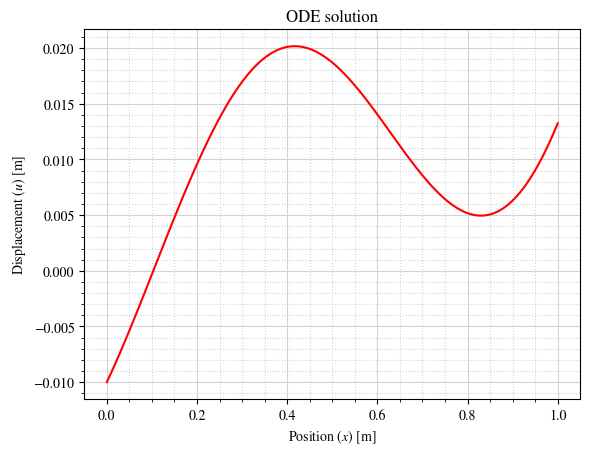

In [89]:
plt.title('ODE solution')
plt.plot(x_range,np.real(u_sol(x_range,L,g)), color='r')
plt.xlabel('Position ($x$) [m]')
plt.ylabel('Displacement ($u$) [m]')
plt.minorticks_on()
plt.grid(True, which='major', zorder=0, color='lightgray', linestyle='-')
plt.grid(True, which='minor', zorder=-1, color='lightgray', linestyle=':')
plt.savefig('figures/solution1.svg',format="svg")
plt.show()

---

#### 3. Formulate the Variational (or Weak) form of the Boundary Value Problem.

In [90]:
v = sp.Function('v')(x)
L,g = sp.symbols('L,g')
b = g*sp.pi**2/L
v_x = v.diff(x)
u_x = u.diff(x)
f = rho*u - s*r

In [91]:
v_x*u_x

Derivative(u(x), x)*Derivative(v(x), x)

In [92]:
weak_form = sp.Eq(sp.Integral(v_x*u_x,(x,0,L)),sp.Integral(v*f,(x,0,L)) + b*v.subs(x,1))
display(weak_form)

Eq(Integral(Derivative(u(x), x)*Derivative(v(x), x), (x, 0, L)), Integral((pi**3*u(x)/L**2 - pi**4*g*x**2/L**4)*v(x), (x, 0, L)) + pi**2*g*v(1)/L)

---

#### 5. Seek an approximation to the solution of this weak form by using basis polynomial basis functions of increasing order (up to order 6)

In [93]:
# # Define a symbolic size 'n'
# n = sp.symbols('n', integer=True)
# # Define a symbolic row vector 'N' with 1 row and n columns
# N = sp.MatrixSymbol('N', 1, n)
# B = sp.MatrixSymbol('B', 1, n)
# c = sp.MatrixSymbol('c', n, 1)
# d = sp.MatrixSymbol('d', n, 1)
# v_x = B*c
# u_x = B*d
# v = N*c
# u = N*d

In [94]:
def solve_u(g_,L_,n):
   '''Returns the function of the displacement: u(x)'''
   # Defining variables
   c = sp.symbols(f'c_1:{n+2}')  # Generates c_1, c_2, ..., c_n
   d = sp.symbols(f'd_1:{n+2}')  # Generates c_1, c_2, ..., c_n
   c = sp.Matrix(c)
   c[0] = 0
   d = sp.Matrix(d)
   N = sp.Matrix([x**i for i in range(n+1)]).T
   B = N.diff()
   K = sp.integrate(B.T*B,(x,0,L))
   A = sp.integrate(rho*N.T*N,(x,0,L))
   D = -((sp.integrate(s/L**2*N.T*x**2,(x,0,L))) - b*N.T.subs(x,1))

   # Define the system
   K_ll = K[1:,1:] - A[1:,1:]
   K_lr = (K[1:,0] - A[1:,0])
   dr = d[0,:]
   Dl = D[1:,:]

   # Converting from symbolic to numeric for efficiency (from sympy to numpy)
   A_system = sp.lambdify(L,K_ll)(L_)
   b_system = sp.lambdify((L,g,dr[0]),Dl-K_lr*dr)(L_,g_,-g_)
   sols = np.linalg.solve(A_system,b_system)
   sols = np.insert(sols.flatten(),0,-g_)

   # Defining the function of the solution
   u_func = sp.lambdify(x,(N*sols).flatten().sum())
   u_func_sym = (N*sols).flatten().sum()
   return u_func,u_func_sym

In [95]:
g_ = 0.01
L_ = 1
u_funcs, u_funcs_sym = zip(*[solve_u(g_=g_,L_=L_,n=i) for i in range(1,7)])
u_funcs = [np.vectorize(u_func) for u_func in u_funcs]

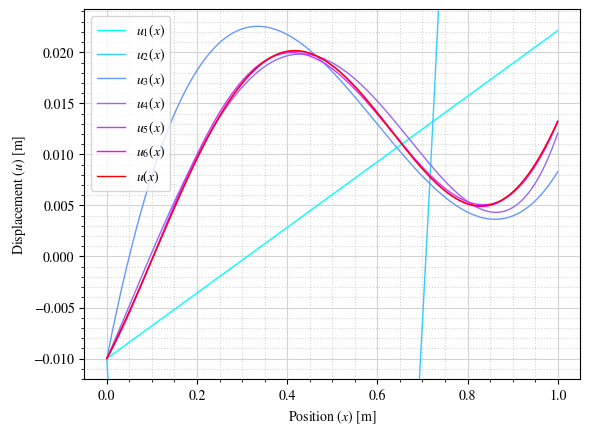

In [96]:
x_range = np.linspace(0,1,int(1e3))
u_funcs_eval = [u_func(x_range) for u_func in u_funcs]
u_sol_eval = np.real(u_sol(x=x_range,L=L_,g=g_))

ax = plt.subplot(1,1,1)
color_idx = np.linspace(0, 1, len(u_funcs))


for i, u_func_eval in enumerate(u_funcs_eval):
    plt.plot(x_range, u_func_eval, label=f'$u_{i+1}(x)$', color=plt.cm.cool(color_idx[i]), linestyle='-', lw=1)

plt.plot(x_range,u_sol_eval, label='$u(x)$', color='r', linestyle='-', lw=1)

plt.xlabel('Position ($x$) [m]')
plt.ylabel('Displacement ($u$) [m]')
plt.minorticks_on()
plt.grid(True, which='major', zorder=0, color='lightgray', linestyle='-')
plt.grid(True, which='minor', zorder=-1, color='lightgray', linestyle=':')
plt.ylim(min(u_sol_eval)*1.2,max(u_sol_eval)*1.2)
plt.legend()
plt.savefig('figures/solution_1_5.svg',format="svg")
plt.show()

---

#### 6. Solve the weak form using linear finite element basis functions. Employ equally sized finite elements

In [97]:
import scipy as sc
# import random

In [98]:
nel = 200
nnod = nel+1
L = 1
b = np.pi**2*g_/L
rho = np.pi**3/L**2
s = g_*np.pi**4/L**2
he = L/nel
he_ = sp.symbols('h_e')
# Ke = np.array([[1, -1],[-1, 1]])/he
ke = [1/he for i in range(nel)] # In case the Ke was not the same for every element, to know what value is associated with each one (generalization)

In [99]:
CN = np.array([[i+1, i+2] for i in range(nel)]) # Element connectivity matrix (node A is connected with node B, its row is the number of the element)
nnodE = CN.shape[1]

##### Calculation of Ke

In [100]:
# Symbolic calculation of Ke and transforming to numeric
xi = sp.symbols('xi')
Ne = 1/2*sp.Matrix([(1-xi),(1+xi)]).T
Be = sp.diff(Ne,xi)*(2/he_) # dx/dξ = he/2 (Be = d(Ne)/dx = d(Ne)/dξ * dξ/dx)
K1 = sp.integrate(Be.T*Be,(xi,-1,1))*(he_/2)
K2 = rho*sp.integrate((Ne.T*Ne),(xi,-1,1))*(he_/2)
Ke_ = K1 - K2 # symbolic
Ke = np.array(Ke_.subs(he_,he)).astype(np.float64) # numeric

##### Assembly of K

In [101]:
Kcoo = sc.sparse.coo_matrix(([],([],[])), shape=(nnod,nnod), dtype=float) # definition of a sparse matrix full of zeros
Klil = Kcoo.tolil() # for easy modification

CN_index_corrected = CN - 1
for el, nodE in enumerate(CN_index_corrected):
    for i in range(nnodE):
        for j in range(nnodE):
            Klil[nodE[i],nodE[j]] += Ke[i,j]
del CN_index_corrected

K = Klil.tocsr() # more efficient for operations
K.__sizeof__()
# K.toarray(), plt.spy(K)

24

In [102]:
K.toarray()

array([[ 199.94832287, -200.02583856,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [-200.02583856,  399.89664574, -200.02583856, ...,    0.        ,
           0.        ,    0.        ],
       [   0.        , -200.02583856,  399.89664574, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,  399.89664574,
        -200.02583856,    0.        ],
       [   0.        ,    0.        ,    0.        , ..., -200.02583856,
         399.89664574, -200.02583856],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        -200.02583856,  199.94832287]])

##### Calculation of Fe
The integral to get Fe is the following, and should be done using a Gauss quadrature

In [103]:
xe = np.array([(CN[el]-1)*he for el in range(nel)])
x_node = np.append(xe[:,0],xe[-1,-1])

In [104]:
def compute_Fe_force(el,xe):
    '''Get the force element vector given the element (el) and the vector of element nodes (xe), using gaussian quadrature (only works for f=x**2)'''
    he = np.diff(xe[el])
    Ne_func = sp.lambdify(xi,Ne)
    Ne_xi_g1, Ne_xi_g2 = Ne_func(-1/np.sqrt(3))[0], Ne_func(1/np.sqrt(3))[0]
    wg1, wg2 = 1, 1
    f_xi_g1 = (Ne_xi_g1*xe[el]).sum()**2
    f_xi_g2 = (Ne_xi_g2*xe[el]).sum()**2
    Fe = ((he/2)*(wg1*Ne_xi_g1*f_xi_g1 + wg2*Ne_xi_g2*f_xi_g2))*(-s/L**2)
    return Fe

In [105]:
def compute_Fe_force_integrating(el,xe,f):
    '''Given a function f, (e.g. f = lambda x: x**2), the element (el) and the vector of elements nodes (xe), returns the force vector of that element'''
    x_of_xi = (Ne*xe[el]).sum()
    Fe = -np.array((s/L**2)*np.diff(xe[el])[0]/2*sp.integrate(f(x_of_xi)*Ne.T, (xi,-1,1)),dtype=float).flatten()
    return Fe

##### Assembly of F

In [106]:
Fcoo = sc.sparse.coo_matrix(([],([],[])), shape=(nnod,1), dtype=float)
Flil = Fcoo.tolil() # for easy modification

CN_index_corrected = CN - 1
for el, nodE in enumerate(CN_index_corrected):
    Fe = compute_Fe_force(el=el, xe=xe) # using gaussian quadrature
    # Fe = compute_Fe_force_integrating(el=el, xe=xe, f=lambda x:x**2) # same result
    for a in range(nnodE):
        Flil[nodE[a],0] += Fe[a]

Flil[-1,0] += b

F = Flil.tocsr()


##### Solution

In [107]:
Klr = K[1:,0]
Kll = K[1:,1:]
Fl = F[1:]
dr = -g_

dl = sc.sparse.linalg.spsolve(Kll, Fl-Klr*dr)

d = np.insert(dl,0,dr)

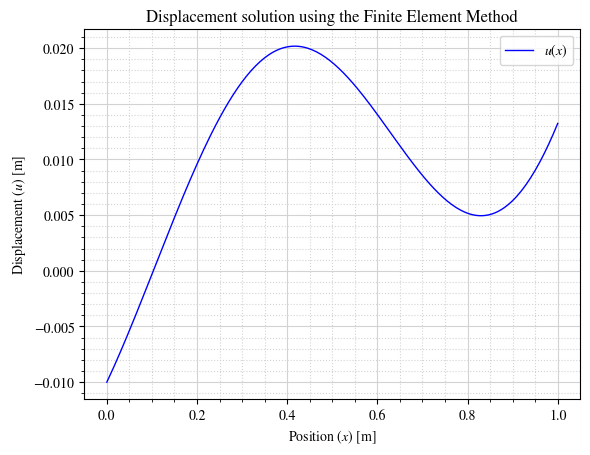

In [108]:
plt.plot(x_node,d, label='$u(x)$', color='blue', linestyle='-', lw=1)
plt.title('Displacement solution using the Finite Element Method')
plt.xlabel('Position ($x$) [m]')
plt.ylabel('Displacement ($u$) [m]')
plt.minorticks_on()
plt.grid(True, which='major', zorder=0, color='lightgray', linestyle='-')
plt.grid(True, which='minor', zorder=-1, color='lightgray', linestyle=':')
# plt.ylim(min(u_sol_eval)*1.2,max(d)*1.2)
# plt.savefig('figures/solution6.svg',format="svg")
plt.legend()
plt.show()

---

#### 7. Solve the problem for increasing number of finite elements and plot the corresponding approximate solutions (for at least four discretizations, of 5, 10, 20 and 40 elements) and compare them with the exact solution.

In [109]:
def fem_solver(nel, L, rho, s, b):
    nnod = nel+1
    he = L/nel
    he_ = sp.symbols('h_e')
    # Ke = np.array([[1, -1],[-1, 1]])/he
    
    CN = np.array([[i+1, i+2] for i in range(nel)]) # Element connectivity matrix (node A is connected with node B, its row is the number of the element)
    nnodE = CN.shape[1]

    # Symbolic calculation of Ke and transforming to numeric
    xi = sp.symbols('xi')
    Ne = 1/2*sp.Matrix([(1-xi),(1+xi)]).T
    Be = sp.diff(Ne,xi)*(2/he_) # dx/dξ = he/2 (Be = d(Ne)/dx = d(Ne)/dξ * dξ/dx)
    K1 = sp.integrate(Be.T*Be,(xi,-1,1))*(he_/2)
    K2 = rho*sp.integrate((Ne.T*Ne),(xi,-1,1))*(he_/2)
    Ke_ = K1 - K2 # symbolic
    Ke = np.array(Ke_.subs(he_,he)).astype(np.float64) # numeric

    Kcoo = sc.sparse.coo_matrix(([],([],[])), shape=(nnod,nnod), dtype=float) # definition of a sparse matrix full of zeros
    Klil = Kcoo.tolil() # for easy modification

    CN_index_corrected = CN - 1
    for el, nodE in enumerate(CN_index_corrected):
        for i in range(nnodE):
            for j in range(nnodE):
                Klil[nodE[i],nodE[j]] += Ke[i,j]
    del CN_index_corrected

    K = Klil.tocsr() # more efficient for operations
    K.__sizeof__()
    # K.toarray(), plt.spy(K)

    xe = np.array([(CN[el]-1)*he for el in range(nel)])
    x_node = np.append(xe[:,0],xe[-1,-1])

    def compute_Fe_force(el,xe):
        '''Get the force element vector given the element (el) and the vector of element nodes (xe), using gaussian quadrature (only works for f=x**2)'''
        he = np.diff(xe[el])
        Ne_func = sp.lambdify(xi,Ne)
        Ne_xi_g1, Ne_xi_g2 = Ne_func(-1/np.sqrt(3))[0], Ne_func(1/np.sqrt(3))[0]
        wg1, wg2 = 1, 1
        f_xi_g1 = (Ne_xi_g1*xe[el]).sum()**2
        f_xi_g2 = (Ne_xi_g2*xe[el]).sum()**2
        Fe = ((he/2)*(wg1*Ne_xi_g1*f_xi_g1 + wg2*Ne_xi_g2*f_xi_g2))*(-s/L**2)
        return Fe

    Fcoo = sc.sparse.coo_matrix(([],([],[])), shape=(nnod,1), dtype=float)
    Flil = Fcoo.tolil() # for easy modification

    CN_index_corrected = CN - 1
    for el, nodE in enumerate(CN_index_corrected):
        Fe = compute_Fe_force(el=el, xe=xe) # using gaussian quadrature
        # Fe = compute_Fe_force_integrating(el=el, xe=xe, f=lambda x:x**2) # same result
        for a in range(nnodE):
            Flil[nodE[a],0] += Fe[a]

    Flil[-1,0] += b

    F = Flil.tocsr()

    Klr = K[1:,0]
    Kll = K[1:,1:]
    Fl = F[1:]
    dr = -g_

    dl = sc.sparse.linalg.spsolve(Kll, Fl-Klr*dr)

    d = np.insert(dl,0,dr)

    return x_node, d

In [110]:
nel_list = [5,10,20,40,80]
x_nodes_vec, d_vec = zip(*[fem_solver(nel=nel, L=L, rho=rho,s=s, b=b) for nel in nel_list])

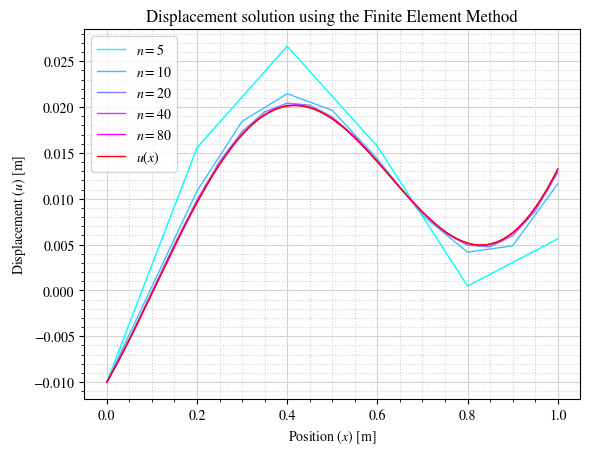

In [111]:
ax = plt.subplot(1,1,1)
color_idx = np.linspace(0, 1, len(x_nodes_vec))
for i in range(len(x_nodes_vec)):
    plt.plot(x_nodes_vec[i],d_vec[i], label=f'$n = {nel_list[i]}$', color=plt.cm.cool(color_idx[i]), linestyle='-', lw=1)

plt.plot(x_range,u_sol_eval, label='$u(x)$', color='r', linestyle='-', lw=1)

plt.title(r'Displacement solution using the Finite Element Method')
plt.xlabel('Position ($x$) [m]')
plt.ylabel('Displacement ($u$) [m]')
plt.minorticks_on()
plt.grid(True, which='major', zorder=0, color='lightgray', linestyle='-')
plt.grid(True, which='minor', zorder=-1, color='lightgray', linestyle=':')
# plt.ylim(min(u_sol_eval)*1.2,max(d)*1.2)
plt.legend()
plt.savefig('figures/solution_1_7_fem.svg',format="svg")
plt.show()

---

## Part 2

#### 2.1 Implement a function able to calculate the approximation error for both $u$ and its derivative $u′$. Plot the error versus the element size on a log-log plot. The approximation error for a given solution uh is given by:
$$
\|e^h\|_{L_2} = \left( \int_0^L \left( u(x) - u^h(x) \right)^2 \, dx \right)^{\frac{1}{2}}
$$

In [112]:
Ne_func = lambda xi: 0.5*np.array([1-xi, 1+xi])
Be_func = lambda he: (1/he)*np.array([-1,1])

def gauss_quadrature(m):
    if m==3:
        xig1, xig3 = np.sqrt(3/5)*np.array([1,-1])
        xig2 = 0
        w1 = w3 = 5/9
        w2 = 8/9
        xigs = [xig1,xig2,xig3]
        ws = [w1,w2,w3]
    return ws,xigs

In [113]:
u_anal = np.real(u_sol(x_range,L_,g_)) # Evaluating the analytic solution of the ODE at the Gaussian point
du_anal = np.real(du_sol(x_range,L_,g_))

In [114]:
def error(nel):
    he = L_/nel
    CN = np.array([[i+1, i+2] for i in range(nel)])
    xe_vec = np.array([(CN[el]-1)*he for el in range(nel)])
    _, d = fem_solver(nel=nel, L=L, rho=rho,s=s, b=b)

    m = 3 # Quadrature points
    ws, xigs = gauss_quadrature(m=m)

    error_u_sq = error_du_sq = 0
    for el in range(nel):
        ue = np.array([d[el],d[el+1]]) # physical displacement at each node
        xe = xe_vec[el] # physical element nodal coordinates
        he = xe[1]-xe[0]

        for i in range(m):
            # In essence, interpolating the displacement between the nodes of the same element to find it in its Gaussian point (using the parent domain to interpolate between (-1,1) -> (u1,u2) where ue=[u1,u2])
            u_fem = (Ne_func(xigs[i])*ue).sum() # Evaluating Ne as a function of xi (parent domain) at the Gaussian point, multiplying with the physical displacement domain (d) to get the displacement at the corresponding Gaussian point (what we are doing is an interpolation between the nodal displacements of that element (given by d) to get the displacement at the gaussian point of the same element (point in between the nodes, position given by xi_g, -1 being the first node of the element, and 1 the opposite))
            du_fem = (Be_func(he)*ue).sum() # Evaluating the derivative of the displacement at the Gaussian point
            
            # In essence, interpolating the nodal positions in the physical domain to find the physical position of the Gaussian point of each element, and using this position to evaluate the displacement (using the parent domain to interpolate between (-1,1) -> (xe1, xe2) where xe=[xe1,xe2])
            x_g = (Ne_func(xigs[i])*xe).sum() # Gaussian point in the element (transforming the Gaussian point (xi_g) from parent (xi) to the physical domain (x)) (can be thought as a change of variable, or particularly, as a linear interpolation from (-1 to 1) -> (xe1,xe2))
            u_anal = np.real(u_sol(x_g,L_,g_)) # Evaluating the analytic solution of the ODE at the Gaussian point
            du_anal = np.real(du_sol(x_g,L_,g_))

            error_u_sq += he/2*ws[i]*(u_fem-u_anal)**2
            error_du_sq += he/2*ws[i]*(du_fem-du_anal)**2

    error_u = np.sqrt(error_u_sq)
    error_du = np.sqrt(error_du_sq)

    return he,error_u,error_du

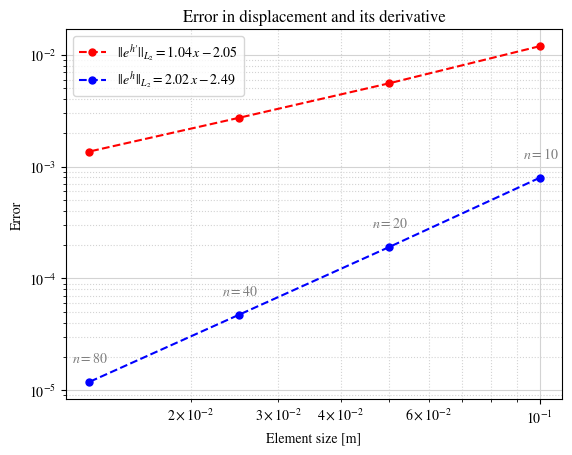

In [126]:
nel_list = [10, 20, 40, 80]
he_vec, error_u_vec, error_du_vec = map(np.array, zip(*[error(nel) for nel in nel_list]))
he_vec = np.round(he_vec,6)
# Perform linear regression using numpy.polyfit (degree 1 for linear)
slope_u_error, intercept_u_error = np.polyfit(np.log(he_vec),np.log(error_u_vec), 1)
slope_du_error, intercept_du_error = np.polyfit(np.log(he_vec),np.log(error_du_vec), 1)

plt.loglog(he_vec,error_du_vec,'--o', color='red', markersize=5, label=f'$||e^{{h\prime}}||_{{L_2}} = {round(slope_du_error,2)}\,x {round(intercept_du_error,2)}$')
plt.loglog(he_vec,error_u_vec,'--o', color='blue', markersize=5, label=f'$||e^h||_{{L_2}} = {round(slope_u_error,2)}\,x {round(intercept_u_error,2)}$')
for x,y,nel in zip(he_vec,error_u_vec,nel_list):
    plt.text(x*.925, y*1.5, f'$n={str(nel)}$', color="gray", fontsize=10)

plt.title(r'Error in displacement and its derivative')
plt.xlabel('Element size [m]')
plt.ylabel('Error')

plt.minorticks_on()
plt.grid(True, which='major', zorder=0, color='lightgray', linestyle='-')
plt.grid(True, which='minor', zorder=-1, color='lightgray', linestyle=':')
# plt.xlim(min(he_vec)*.9,max(he_vec)*1.15)
plt.legend()
plt.savefig('figures/solution_2_1.svg',format="svg")
plt.show()

# FIX X AXIS TICKS